### 이미지 이항분류 짝수/홀수 인식

In [18]:
import warnings
warnings.filterwarnings(action='ignore')

import os
import time

import numpy as np
import pandas as pd
import seaborn as sb

from tensorflow.keras.models import Sequential  # class
from tensorflow.keras.models import load_model  # model 사용
from tensorflow.keras.layers import Dense       # 전결합
from tensorflow.keras.layers import Dropout     # 특정 node를 사용안함.
from tensorflow.keras.callbacks import EarlyStopping   # 학습 자동 중지
from tensorflow.keras.callbacks import ModelCheckpoint # 우수한 학습 모델 파일 저장
from tensorflow.keras import regularizers 
from tensorflow.keras.utils import to_categorical   # one-hot 엔코딩

from tensorflow.keras.datasets import mnist

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # 학습셋과 테스트셋의 분리 지원
from sklearn.model_selection import StratifiedKFold  # K겹 교차 검증

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

font_name = font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name()
# windows 10
# font_name = font_manager.FontProperties(fname="C:/Windows/Fonts/malgunsl.ttf").get_name()
rc('font', family=font_name)           # 맑은 고딕 폰트 지정
plt.rcParams["font.size"] = 12         # 글자 크기
# plt.rcParams["figure.figsize"] = (10, 4) # 10:4의 그래프 비율
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정

%matplotlib inline  

In [19]:
# 최초에만 다운로드 발생
(x_train, y_train), (x_test, y_test)  = mnist.load_data()
width=28
height=28

print('x_train:', x_train.shape)
# 전결합층은 1차원 형태의 나열된 데이터여야함.
x_train = x_train.reshape(x_train.shape[0], width * height).astype('float32') / 255 # 60000행  X 784열
print('x_train:', x_train.shape)

x_test = x_test.reshape(x_test.shape[0], width * height).astype('float32') / 255 # 10000 X 784

# 홀수는 1, 짝수는 0
y_train = y_train % 2
print(y_test[0:10])
y_test = y_test % 2
print('이항분류 적용: ',y_test[0:10])
# 7은 1이라 학습, 2는 2이라 학습시킴

x_train: (60000, 28, 28)
x_train: (60000, 784)
[7 2 1 0 4 1 4 9 5 9]
이항분류 적용:  [1 0 1 0 0 1 0 1 1 1]


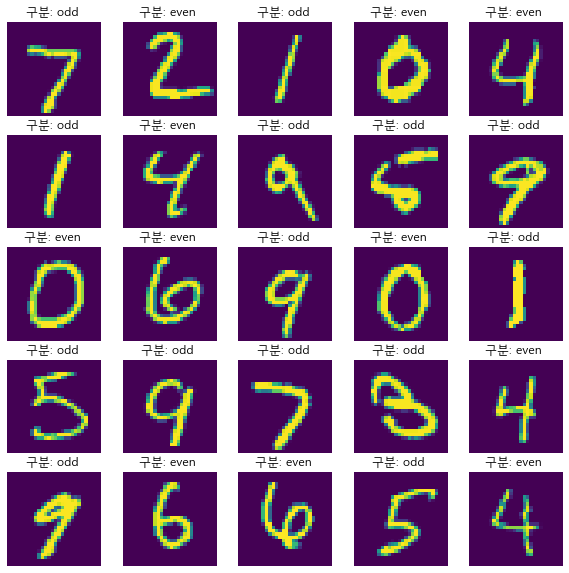

In [20]:
# 데이터 확인
plt_row = 5
plt_col = 5

plt.rcParams["figure.figsize"] = (10,10) # 이미지 사이즈 설정

f, axarr = plt.subplots(plt_row, plt_col) # 5행 5열 배열 plot 구조 생성

for i in range(plt_row * plt_col): # 25: 0 ~ 24
    sub_plt = axarr[i // plt_row, i % plt_col] # 행열 위치 설정
    sub_plt.axis('off') # 축 label 출력 생략
    
    # 1차원 배열 -> 2차원 배열로 변경
    # 2차원 이미지로 출력하기위해 784 -> 28행 28열로 변경
    sub_plt.imshow(x_test[i].reshape(width, height))  
    
    sub_plt_title = '구분: ' 
    
    if y_test[i] :  # 1: True, 0: False
        sub_plt_title += 'odd '  # 1, 홀수
    else:
        sub_plt_title += 'even ' # 0, 짝수
    
    sub_plt.set_title(sub_plt_title) # 이미지 제목

plt.show()

### MLP

In [21]:
seed = 0 # 난수용 
width=28
height=28

(x_train_all, y_train_all), (x_test, y_test)  = mnist.load_data()

x_train_all = x_train_all.reshape(x_train_all.shape[0], width * height).astype('float32') / 255 # 60000행  X 784열
x_test = x_test.reshape(x_test.shape[0], width * height).astype('float32') / 255 # 10000 X 784

# 홀수는 1, 짝수는 0
y_train_all = y_train_all % 2
y_test = y_test % 2
print(y_train[0:10])

# 80%: 훈련, 20%: 검증
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all,
                                                  stratify=y_train_all,
                                                  test_size=0.2,
                                                  random_state=seed)

model = Sequential()
model.add(Dense(4, input_dim=784, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', 
                                metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='loss', patience=1)
start = time.time()
# 장비 속도가 느려 3번만 진행
hist = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=3, 
                 batch_size=50, callbacks=[early_stopping])
end = time.time()
print('Runtime: {0:.2f} 초'.format(end-start))

# MLP기반에 CPU, GPU 사용시 왜 GUP가 느린 이유
# - 데이터가 아주 작을 경우, CPU가 GPU를 제어하는 시간 필요
# - Dense는 CPU에 최적화 되어 학습되는 구조
# - Dense에서도 가중치와 편향이 많아지면 GPU가 빨라짐.
# cpu: 62 초
# gpu: 241 초

[1 0 0 1 1 0 1 1 1 0]
Train on 48000 samples, validate on 12000 samples
Epoch 1/3
48000/48000 [==============================] - 2s 39us/sample - loss: 0.2507 - accuracy: 0.9010 - val_loss: 0.1714 - val_accuracy: 0.9408
Epoch 2/3
48000/48000 [==============================] - 1s 31us/sample - loss: 0.1522 - accuracy: 0.9481 - val_loss: 0.1467 - val_accuracy: 0.9486
Epoch 3/3
48000/48000 [==============================] - 1s 31us/sample - loss: 0.1337 - accuracy: 0.9536 - val_loss: 0.1354 - val_accuracy: 0.9545
Runtime: 4.87 초


In [22]:
yp = model.predict(x_test, batch_size=32)
print(yp[0:10])

[[0.99980927]
 [0.02091062]
 [0.9605992 ]
 [0.00278169]
 [0.15778074]
 [0.98276764]
 [0.1408422 ]
 [0.9540837 ]
 [0.52203864]
 [0.95801044]]


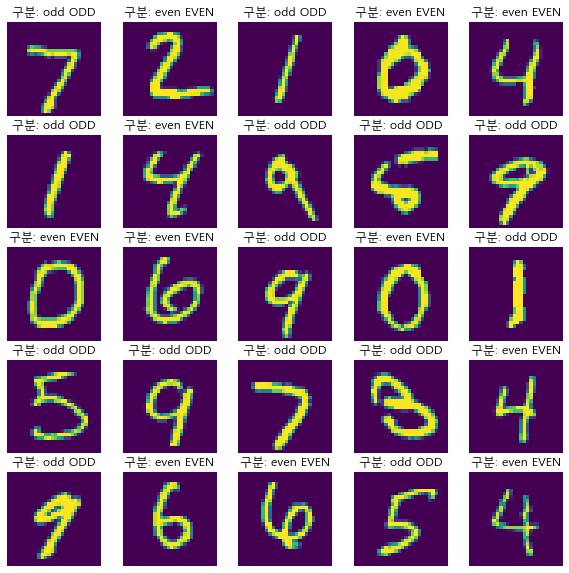

In [23]:
# 결과 확인
plt_row = 5
plt_col = 5

plt.rcParams["figure.figsize"] = (10,10) # 이미지 사이즈 설정

f, axarr = plt.subplots(plt_row, plt_col) # 5행 5열 배열 plot 구조 생성

for i in range(plt_row*plt_col): # 25: 0 ~ 24
    sub_plt = axarr[i//5, i%5] # 행열 위치 설정
    sub_plt.axis('off') # 축 label 출력 생략
    
    # 1차원 배열 -> 2차원 배열로 변경
    # 이미지로 출력하기위해 784 -> 28행 28열로 변경
    sub_plt.imshow(x_test[i].reshape(width, height))  
    
    sub_plt_title = '구분: ' 
    
    if y_test[i] :  # 1: True, 0: False
        sub_plt_title += 'odd '  # 1, 홀수
    else:
        sub_plt_title += 'even ' # 0, 짝수
        
    # 예측한 값 출력
    if yp[i] >= 0.5:
        sub_plt_title += 'ODD'
    else:
        sub_plt_title += 'EVEN'
    
    sub_plt.set_title(sub_plt_title) # 이미지 제목

plt.show()

In [24]:
    model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 4)                 3140      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 3,145
Trainable params: 3,145
Non-trainable params: 0
_________________________________________________________________


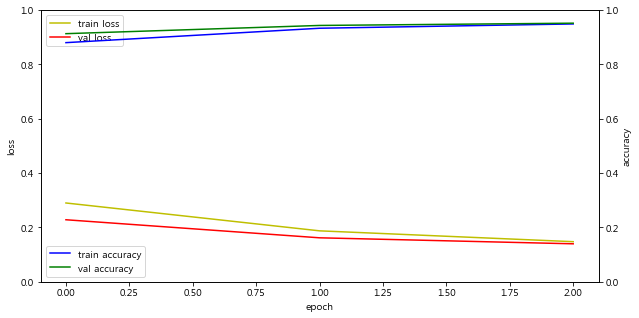

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline  

fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

acc_ax = loss_ax.twinx()  # 오른쪽 y 출 설정

# 왼쪽 y 축 설정
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 1.0]) # 값을 반영하여 변경

# 오른쪽 y 축 설정
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val accuracy')
acc_ax.set_ylim([0.0, 1.0])

# 축 레이블 설정
loss_ax.set_xlabel('epoch')  # 학습 횟수
loss_ax.set_ylabel('loss')   # 왼쪽 y축 레이블, 오차
acc_ax.set_ylabel('accuracy') # 오른쪽 y축 레이블, 정확도

loss_ax.legend(loc='upper left') # 오차 레이블 위치
acc_ax.legend(loc='lower left')  # 정확도 레이블 위치

plt.show()

In [7]:
test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=1, verbose=0)
print('손실값:', test_loss, '/정확도:', (test_acc*100), '%')

손실값: 0.13999092670152252 /정확도: 95.03999948501587 %


In [8]:
model.save('./Mnist_mlp.h5')

In [9]:
model = load_model('./Mnist_mlp.h5')